<a href="https://colab.research.google.com/github/pedrotorres08/DadosSetorEletrico/blob/main/DadosAbertosANEEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1- Introdução**

**Leitura da base de dados abertos da ANEEL**
<br>
-Acesso via link: https://dadosabertos.aneel.gov.br/dataset/
<br>
-Os dados podem ser acessados via API do CKAN, e estão estruturados em formato JSON
<br><br>
Como exemplo, vamos fazer a leitura dos valores de TUSD e TE homologados para cada distribudora, que podem ser obtidos na seguinte página:
<br>
https://dadosabertos.aneel.gov.br/dataset/tarifas-distribuidoras-energia-eletrica
<br>
e clicando-se no link para o arquivo .csv

Para fazer a leitura dos dados via API, primeiramente é preciso identificar a 
ID do dataset a ser lido, que pode ser visualizada no endereço da página:
<br><br>
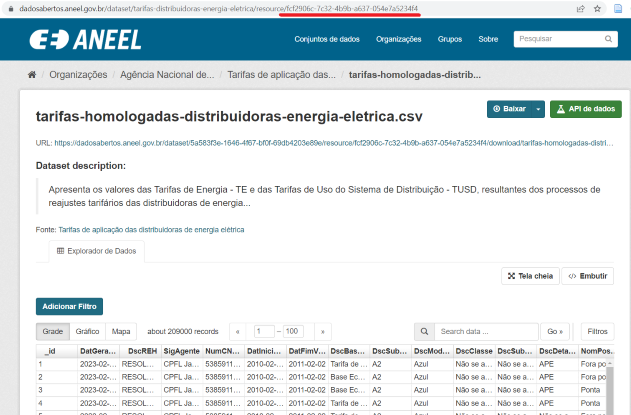

**2 - Implementação em Python**


Para fazer a leitura, utilizaremos a função de leitura de arquivos em formato JSON embutida no Pandas:

In [1]:
import pandas as pd

In [2]:
#url para acesso ao portal de dados abertos da ANEEL
url_base = 'https://dadosabertos.aneel.gov.br/api/3/action/datastore_search?resource_id='

#ID do dataset no portal de dados abertos da ANEEL
rid = 'fcf2906c-7c32-4b9b-a637-054e7a5234f4' #ID Tarifas

In [3]:
#Ler apenas a primeira linha do dataset e determinar o numero total de linhas (n_max)
url = '{}{}&limit={}&offset={}'.format(url_base,rid,1,0)
df = pd.read_json(url)
df_res = pd.DataFrame(df.result.records)
n_max = df.result.total
print("Número total de entradas: {}".format(n_max))

Número total de entradas: 208967


In [4]:
#Agora, fazer a leitura dos demais dados (da segunda linha até n_max)
limite = 32000 #limite padrão do CKAN para uma única leitura
for offset in range(1,n_max,limite):
  print("Leitura do dataset... {:.2f} %".format(offset/n_max*100))
  url = '{}{}&limit={}&offset={}'.format(url_base,rid,limite,offset)
  df_res = pd.concat([df_res, pd.DataFrame(pd.read_json(url).result.records)], ignore_index=True)

Leitura do dataset... 0.00 %
Leitura do dataset... 15.31 %
Leitura do dataset... 30.63 %
Leitura do dataset... 45.94 %
Leitura do dataset... 61.25 %
Leitura do dataset... 76.57 %
Leitura do dataset... 91.88 %


In [5]:
#Substituir , por . nas colunas com valores numéricos 
df_res['VlrTUSD'] = df_res['VlrTUSD'].replace(',','.',regex=True)
df_res['VlrTE'] = df_res['VlrTE'].replace(',','.',regex=True)

#Converter o tipo de dados para float
df_res['VlrTUSD'] = df_res['VlrTUSD'].astype(float)
df_res['VlrTE'] = df_res['VlrTE'].astype(float)

In [26]:
#Filtrar apenas as tarifas mas recentes aplicadas ao subgrupo B1, convencional residencial
df_filt = df_res[(df_res.DscSubGrupo == 'B1') & (df_res.DscModalidadeTarifaria == 'Convencional') & (df_res.DscSubClasse == 'Residencial') & (df_res.DscBaseTarifaria == 'Tarifa de Aplicação')].sort_values('DatFimVigencia').groupby('SigAgente').last()
df_filt = df_filt[['VlrTUSD', 'VlrTE']].reset_index(level=0)


Text(0, 0.5, 'TUSD [R$/MWh], TE [R$/MWh]')

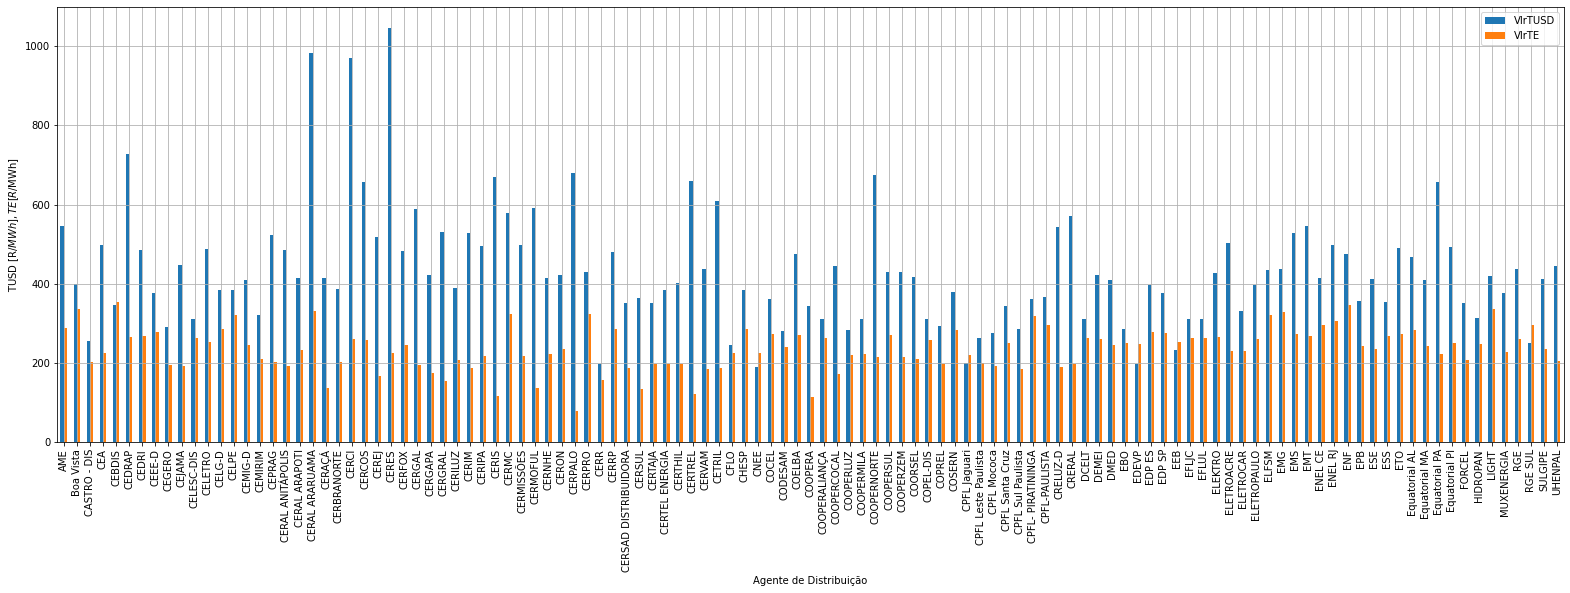

In [33]:
#Plotar as tarifas
ax = df_filt.plot(x="SigAgente", y=["VlrTUSD", "VlrTE"], kind="bar", figsize=(27, 8), grid=True)
ax.set_xlabel("Agente de Distribuição")
ax.set_ylabel("TUSD [R$/MWh], TE [R$/MWh]")